# Outline

- [1 - Packages](#1)
- [2 - Importing Data](#2)
    - [2.1 - Prepare Data for Merging](#2.1)
- [3 - Data Preprocessing](#3)
- [4 - Model Selection💡](#4)
- [5 - Model Training and Fine Tuning](#5)
- [6 - Evaluation](#6)
- [7 - Submission](#7)

# Context

**Microscopic Parasite Detection**

In the field of medical parasitology. Our meticulously curated dataset contains microscopic images, expertly annotated into 15 distinct parasite classes. Our objectives include developing **Deep Learning** model to aid medical professionals, enhance diagnostics, and optimize healthcare resources. This project's significance lies in early intervention, resource allocation, and global health impact.

# Data Description :

Microscopic Image Classification Dataset for `Parasite Detection`. This dataset is a valuable resource for the field of medical parasitology and data science. It consists of a diverse collection of labeled microscopic images, each belonging to one of the 15 distinct classes representing various parasitic organisms. In this data description, we provide an overview of the classes, their meanings, and insights into the dataset structure.


1. **Ascariasis** (class_0): Images in this class depict the parasitic infection caused by Ascaris lumbricoides, a type of roundworm.

2. **Babesia** (class_1): This class represents the Babesia genus, which includes parasites that infect red blood cells and can lead to a disease known as babesiosis.

3. **Capillaria p** (class_2): Images here correspond to Capillaria philippinensis, a parasitic nematode known to infect the intestines.

4. **Enterobius v** (class_3): Class_3 includes images related to Enterobius vermicularis, commonly referred to as the pinworm, which infests the human gastrointestinal tract.

5. **Epidermophyton floccosum** (class_4): Images in this class pertain to the dermatophyte fungus Epidermophyton floccosum, responsible for causing skin infections.

6. **Fasciolopsis buski** (class_5): Class_5 represents the parasitic trematode Fasciolopsis buski, which infects the human intestines.

7. **Hookworm egg** (class_6): This class contains images of hookworm eggs, representing infections caused by various species of hookworms.

8. **Hymenolepis diminuta** (class_7): Images in this class depict the tapeworm Hymenolepis diminuta, a parasite found in the small intestines of rodents.

9. **Hymenolepis nana** (class_8): Class_8 represents Hymenolepis nana, a tapeworm that infects humans and rodents.

10. **Leishmania** (class_9): Images in this class are related to Leishmania parasites, which cause a group of diseases called leishmaniasis.

11. **Opisthorchis viverrine** (class_10): This class includes images of Opisthorchis viverrini, a liver fluke that infects humans through the consumption of raw or undercooked fish.

12. **Paragonimus spp** (class_11): Class_11 represents the Paragonimus genus, which includes lung flukes causing paragonimiasis, a lung infection.

13. **T. rubrum** (class_12): Images in this class pertain to Trichophyton rubrum, a fungus responsible for various dermatophytosis infections.

14. **Taenia spp** (class_13): Class_13 includes images related to the Taenia genus, encompassing tapeworms that infect humans and animals.

15. **Trichuris trichiura** (class_14): This class contains images of Trichuris trichiura, a whipworm that infects the human large intestine.


<a name='1'></a>
# 1 - Packages

In [1]:
import warnings 
warnings.filterwarnings('ignore')

!pip install tensorflow_addons

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping , LearningRateScheduler

from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D,\
Dense, Flatten, Dropout , GlobalAveragePooling2D , BatchNormalization , MaxPool2D , Input
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.saving import load_model
from tensorflow_addons.metrics import F1Score
from sklearn.metrics import confusion_matrix, classification_report

import os,pathlib,shutil , zipfile , random
import pandas as pd,numpy as np, matplotlib.pyplot as plt, seaborn as sns

<a name='2'></a>
# 2 - Importing Data

In [2]:
os.environ['KAGGLE_USERNAME'] = 'sayedgamal99'
os.environ['KAGGLE_KEY'] = '4179995e897c2f2d637b366d708bb2ef'
!kaggle competitions download -c ieee-mansb-victoris-2-final-competition

100%|███████████████████████████████████████▊| 956M/959M [00:38<00:00, 21.4MB/s]
100%|████████████████████████████████████████| 959M/959M [00:38<00:00, 25.8MB/s]


<a name='2.1'></a>
# 2.1 - Prepare Data for Merging

In [3]:
dir_zip = zipfile.ZipFile('ieee-mansb-victoris-2-final-competition.zip','r')
dir_zip.extractall('ieee-mansb-victoris-2-final')
dir_zip.close()


destination_directory = 'final-data'
source_dirctory_1 =  'ieee-mansb-victoris-2-final/train_Images_Source_1'
source_directory_2 = 'ieee-mansb-victoris-2-final/train_Images_Source_2'

for subdirectory in os.listdir(source_dirctory_1):
    source_path = os.path.join(source_dirctory_1, subdirectory)
    destination_path = os.path.join(destination_directory, subdirectory)
    shutil.copytree(source_path, destination_path)

for filename in os.listdir(source_directory_2):
    source_file = os.path.join(source_directory_2, filename)
    person_name = filename.split('_')[0]
    person_folder = os.path.join(destination_directory, person_name)
    if not os.path.exists(person_folder):
        os.makedirs(person_folder)
    shutil.copy2(source_file, os.path.join(person_folder, filename))

In [4]:
source_folder = "final-data"
train_folder = "train-data"
validation_folder = "validation-data"

for class_folder in os.listdir(source_folder):
    if os.path.isdir(os.path.join(source_folder, class_folder)):
        os.makedirs(os.path.join(validation_folder, class_folder), exist_ok=True)

validation_percentage = 10

for class_folder in os.listdir(source_folder):
    if os.path.isdir(os.path.join(source_folder, class_folder)):
        class_source = os.path.join(source_folder, class_folder)
        class_validation = os.path.join(validation_folder, class_folder)

        images = [f for f in os.listdir(class_source) if f.endswith((".jpg", ".png"))]
        num_validation = int(len(images) * (validation_percentage / 100))
        validation_images = random.sample(images, num_validation)

        for image in validation_images:
            source_path = os.path.join(class_source, image)
            destination_path = os.path.join(class_validation, image)
            shutil.move(source_path, destination_path)
shutil.move(source_folder, train_folder)

'train-data'

<a name='3'></a>
# 3 - Data Preprocessing

In [5]:
from keras.preprocessing.image import ImageDataGenerator

input_shape = (224,224,3)

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,     
    rotation_range=20,
    horizontal_flip =True,
    vertical_flip = True ,
    fill_mode ='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale=1.0 / 255 
)

train_generator = train_datagen.flow_from_directory(
    'train-data',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='training',
)

validation_generator = validation_datagen.flow_from_directory(
    'validation-data',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
)


Found 10723 images belonging to 15 classes.
Found 1187 images belonging to 15 classes.


In [6]:
class_indices = train_generator.class_indices
labels = {value: key for key, value in class_indices.items()}

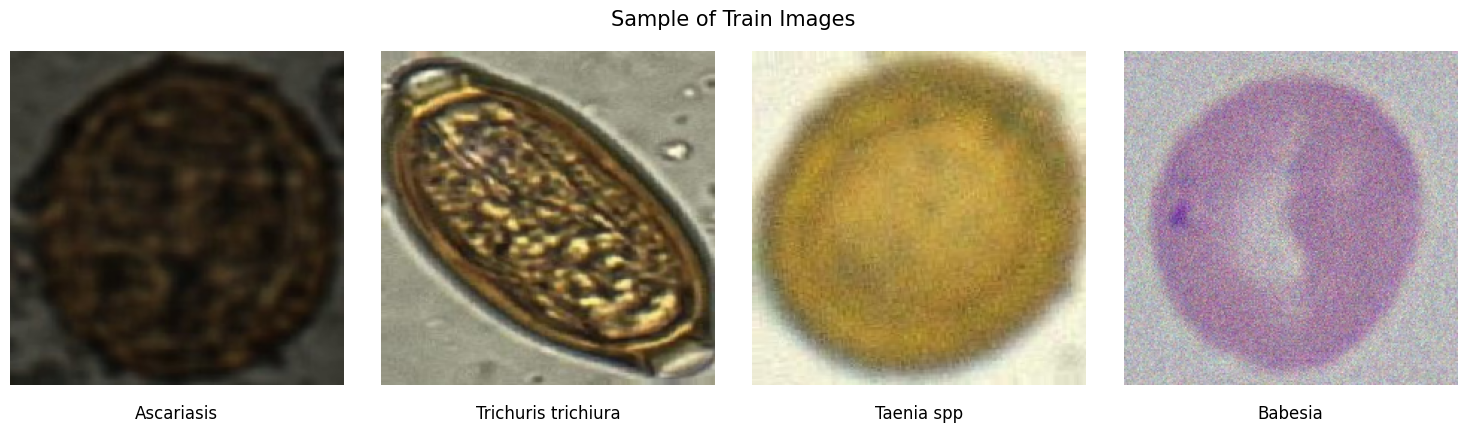

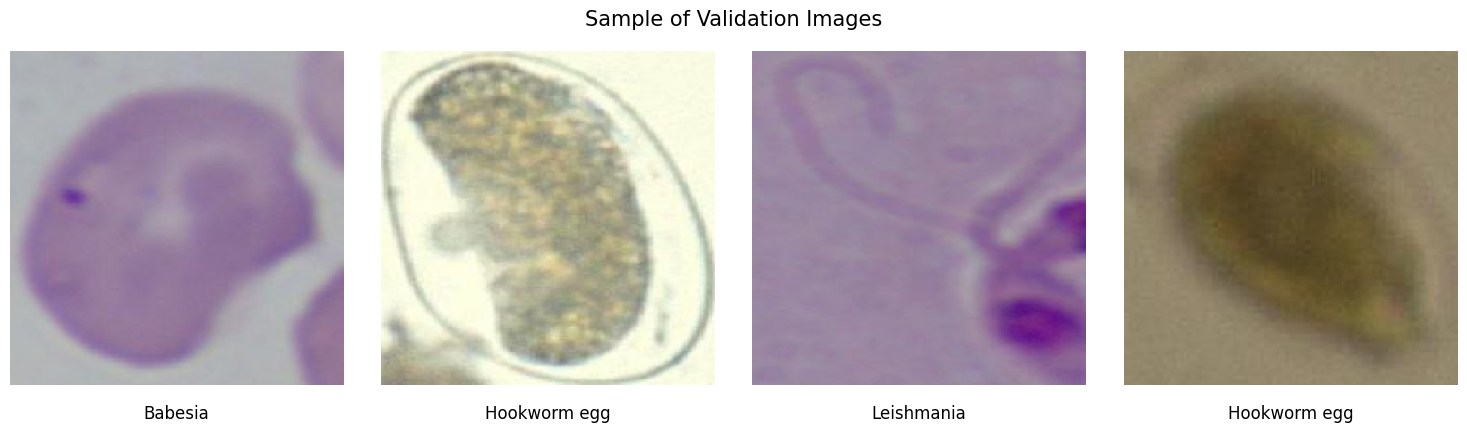

In [7]:
def showthem(subset='train'):
    plt.figure(figsize=(15, 4))
    gen = train_generator  if subset=='train' else validation_generator
    title = 'Sample of Train Images' if subset=='train' else 'Sample of Validation Images'
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        img, label = gen.next()
        plt.imshow(img[0])

        # Add text label
        plt.text(0.5, -0.1, f"{labels[np.argmax(label[0])]}", transform=plt.gca().transAxes, fontsize=12, ha='center')
        plt.axis('off')
    plt.suptitle(title,size=15)
    plt.tight_layout()
    plt.show()

showthem()
showthem("validation")

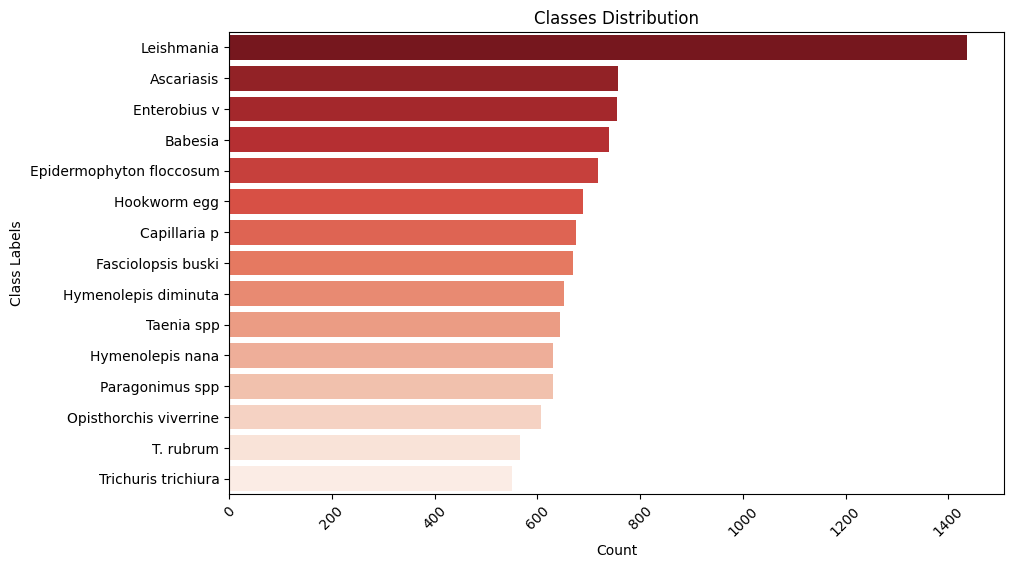

In [8]:
class_counts = train_generator.classes
class_labels = list(train_generator.class_indices.keys())
counts=[class_counts.tolist().count(i) for i in range(len(class_labels))]

dd = pd.DataFrame({'labels': class_labels, 'counts': counts})
dd = dd.sort_values(by='counts', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='counts', y='labels', data=dd, palette='Reds_r')
plt.xlabel('Count')
plt.ylabel('Class Labels')
plt.title('Classes Distribution')
plt.xticks(rotation=45)
plt.show()

there is imbalance in our data set

<a name='4'></a>
# 4 - Model Selection💡

 After experimenting with several base models, we found that `ResNet101V2` consistently outperforms the others and is our top choice.

### base Model

In [15]:
base_model = ResNet101V2(
    input_shape=(224, 224, 3), 
    include_top=False,  
    weights='imagenet',  
)

base_model.trainable = True

### Custom Classifier

In [16]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(15, activation='softmax')  
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 15)                15375     
                                                      

<a name='5'></a>
# 5 - Model Training and Fine Tuning

In [17]:
def lr_schedule(epoch):
    initial_lr =4.5e-5
    decrease_factor = 1.5    
    if epoch >= 8:
        return initial_lr / (decrease_factor * (epoch // 8))
    return initial_lr

lr_scheduler = LearningRateScheduler(lr_schedule)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, verbose=1 )
early_stopping = EarlyStopping(patience=12, restore_best_weights=True )

In [18]:
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=[
        F1Score(num_classes=15, average='micro'),'accuracy'
    ]
)

### Computing Classes Weights

to solve the problem of imbalance

In [19]:
class_labels = train_generator.classes
class_weights = compute_class_weight('balanced' ,classes=np.unique(class_labels), y=class_labels)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 0.9430958663148636, 1: 0.9673432566531349, 2: 1.0574950690335305, 3: 0.9455908289241622, 4: 0.9956360259981429, 5: 1.0685600398604882, 6: 1.0375423318819545, 7: 1.0981054787506401, 8: 1.1347089947089948, 9: 0.4974715843191835, 10: 1.1777045579352003, 11: 1.1347089947089948, 12: 1.260787771898883, 13: 1.1083204134366924, 14: 1.2973986690865094}


In [20]:
history = model.fit(
    train_generator,
    epochs=100,  
    validation_data=validation_generator,
    callbacks=[
        lr_scheduler,
        checkpoint, early_stopping],
    class_weight = class_weight_dict
)

Epoch 1/100
336/336 [==============================] - ETA: 0s - loss: 0.9898 - f1_score: 0.6998 - accuracy: 0.6998
Epoch 1: val_loss improved from inf to 0.23515, saving model to best_model.h5
336/336 [==============================] - 238s 516ms/step - loss: 0.9898 - f1_score: 0.6998 - accuracy: 0.6998 - val_loss: 0.2352 - val_f1_score: 0.9275 - val_accuracy: 0.9275 - lr: 4.5000e-05
Epoch 2/100
336/336 [==============================] - ETA: 0s - loss: 0.3114 - f1_score: 0.9037 - accuracy: 0.9037
Epoch 2: val_loss improved from 0.23515 to 0.17261, saving model to best_model.h5
336/336 [==============================] - 169s 502ms/step - loss: 0.3114 - f1_score: 0.9037 - accuracy: 0.9037 - val_loss: 0.1726 - val_f1_score: 0.9419 - val_accuracy: 0.9419 - lr: 4.5000e-05
Epoch 3/100
336/336 [==============================] - ETA: 0s - loss: 0.2178 - f1_score: 0.9323 - accuracy: 0.9323
Epoch 3: val_loss improved from 0.17261 to 0.13522, saving model to best_model.h5
336/336 [=============

<a name='6'></a>
# 6 - Evaluation

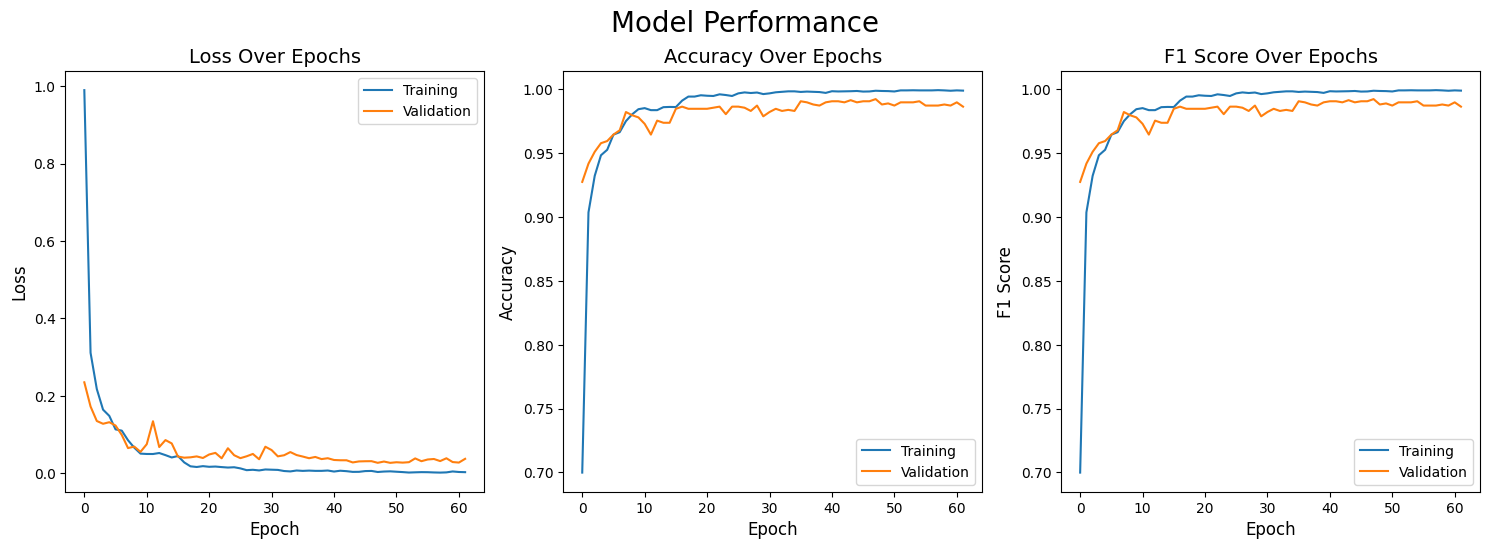

In [21]:
history_dict = history.history
metrics_to_plot = {
    'Loss': ('loss', 'val_loss'),
    'Accuracy': ('accuracy', 'val_accuracy'),
    'F1 Score': ('f1_score', 'val_f1_score')
}

plt.figure(figsize=(15, 10))

for i, (metric_name, (train_metric, val_metric)) in enumerate(metrics_to_plot.items(), 1):
    plt.subplot(2, 3, i)
    plt.plot(history_dict[train_metric], label='Training')
    plt.plot(history_dict[val_metric], label='Validation')
    plt.title(f'{metric_name} Over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.legend()

plt.suptitle('Model Performance',size=20)
plt.tight_layout()
plt.show()

In [22]:
model = load_model('best_model.h5') 

In [23]:
val_set_final = validation_datagen.flow_from_directory(
    'validation-data',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1187 images belonging to 15 classes.


In [24]:
num_steps = len(val_set_final )
predictions_val = model.predict_generator(val_set_final, steps=num_steps, verbose=1)


38/38 [==============================] - 6s 112ms/step


In [25]:
val_loss ,val_acc, val_f1 = model.evaluate(val_set_final)

38/38 [==============================] - 6s 118ms/step - loss: 0.0271 - f1_score: 0.9890 - accuracy: 0.9890


In [26]:
true_labels = val_set_final.classes
predicted_labels = np.argmax(predictions_val, axis=1)
predicted_labels

array([ 0,  0,  0, ..., 14, 14, 14])

In [27]:
conf_mat = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
conf_mat = pd.DataFrame(conf_mat, index=validation_generator.class_indices.keys(), columns=validation_generator.class_indices.keys())

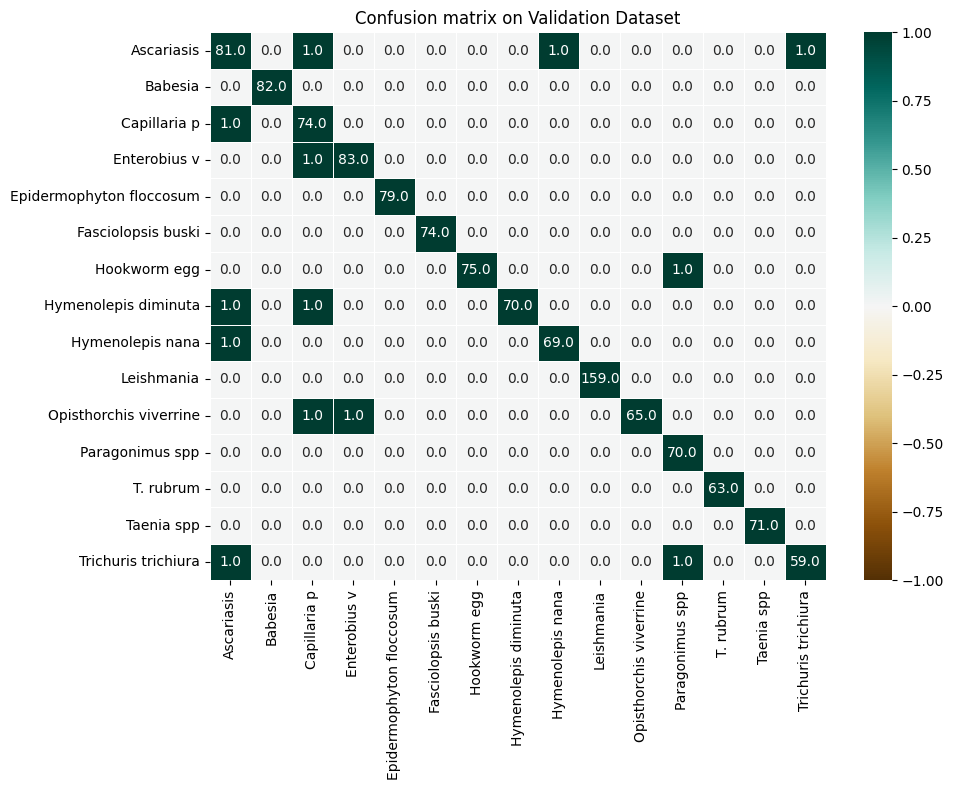

In [28]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat,ax=ax ,cmap='BrBG',center=0,vmin=-1,vmax=1,annot=True,fmt='.1f',linewidth=.5)
ax.set_title('Confusion matrix on Validation Dataset')
plt.tight_layout()
plt.show()

In [29]:
misclassified_indices = np.where(predicted_labels != true_labels)[0]

misclassified_filenames = [validation_generator.filenames[i] for i in misclassified_indices]
true_labels_misclassified = [true_labels[i] for i in misclassified_indices]
predicted_labels_misclassified = [predicted_labels[i] for i in misclassified_indices]

print("Number of Missed Classes : {}".format(len(misclassified_filenames)))

Number of Missed Classes : 13


<a name='7'></a>
# 7 - Submission

In [30]:
test_data_path = 'ieee-mansb-victoris-2-final/test_data'

In [31]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    os.path.dirname(test_data_path), 
    target_size=(input_shape[0], input_shape[0]), 
    batch_size=32,
    classes=[os.path.basename(test_data_path)], 
    class_mode=None, 
    shuffle=False,  
)

Found 5108 images belonging to 1 classes.


In [32]:
num_steps = len(test_generator)
predictions = model.predict(test_generator, steps=num_steps, verbose=1)
image_file_names = [os.path.basename(path) for path in test_generator.filenames]
predicted_labels = np.argmax(predictions, axis=1)

160/160 [==============================] - 24s 138ms/step


In [33]:
class_labels = {v: k for k, v in class_indices.items()}
predicted_class_names = [class_labels[label] for label in predicted_labels]

In [34]:
submission = pd.DataFrame(predictions )
submission.columns = ['class_' + str(col) for col in submission.columns]
submission.insert(0,'image_name',image_file_names)

In [35]:
submission.sample()

,image_name,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,class_10,class_11,class_12,class_13,class_14
316,1282.jpg,1.045809e-09,3.341692e-09,7.688647e-08,1.0,9.476057e-10,4.375059e-10,2.510614e-09,2.762192e-09,3.453120e-08,4.692512e-09,4.505082e-09,1.150833e-10,1.883422e-08,1.060091e-08,2.606536e-09


Save the submission

In [36]:
submission.to_csv('submission.csv', index=False)

In [37]:
!kaggle competitions submit -c ieee-mansb-victoris-2-final-competition -f submission.csv -m "BEAST"

100%|███████████████████████████████████████| 1.01M/1.01M [00:01<00:00, 971kB/s]
Successfully submitted to IEEE ManSB VICTORIS 2.0 Final Competition

In [38]:
!kaggle competitions submissions -c ieee-mansb-victoris-2-final-competition | head -n 3

fileName                                date                 description  status    publicScore  privateScore  
--------------------------------------  -------------------  -----------  --------  -----------  ------------  
submission.csv                          2023-09-21 16:40:33  BEAST        complete  0.00847      0.00698       
